# Startup

In [38]:
# @title --=== RUN TO START ===-- (Imports and Definitions)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.keras import TqdmCallback

SHEET_ID = '1OdllC9j05ka_adHvipTn58XPqmLt5f1VLBzHFd9aRJQ'
SHEET_NAME = 'GoL'
SLEEP = 1.5

results = {}


class RecursiveModel(tf.keras.models.Model):
    def __init__(self, core_model, n_times, **kwargs):
        super().__init__(**kwargs)
        self.core_model = core_model
        self.n_times = n_times

    def call(self, inputs):
        x = inputs
        for _ in range(self.n_times):
            x = self.core_model(x)
        return x


def get_filter_coords(point_coords):
  """
  x0y0 xiy0 x2y0
  x0yi xiyi x2yi
  x0y2 xiy2 x2y2
  """
  xi, yi = point_coords

  x0 = xi - 1
  x2 = xi + 1
  y0 = yi - 1
  y2 = yi + 1

  ul = (x0, y0)  # upper left
  uc = (xi, y0)  # upper center
  ur = (x2, y0)  # upper right
  ml = (x0, yi)  # middle left
  #mc = (xi, yi)  # middle center
  mr = (x2, yi)  # middle right
  ll = (x0, y2)  # lower left
  lc = (xi, y2)  # lower center
  lr = (x2, y2)  # lower right

  filter_coords = ul, uc, ur, ml, mr, ll, lc, lr

  return filter_coords


def read_coord(board, coord):
  shape_y, shape_x = board.shape
  xi, yi = coord
  if (xi < 0) or (yi < 0):
    return 0
  if (xi >= shape_x) or (yi >= shape_y):
    return 0
  return board[xi][yi]


def read_filter(board, filter_coords):
  for coord in filter_coords:
    yield read_coord(board, coord)


def play_a_cell(board, cell_coords):
  initial_state = read_coord(board, cell_coords)
  filter_coords = get_filter_coords(cell_coords)
  sum_neighbours = sum(read_filter(board, filter_coords))
  if sum_neighbours == 3:
    return 1
  if sum_neighbours == 2:
    return initial_state
  return 0


def play(board, padding=0, show=False) -> pd.DataFrame:
  shape_y, shape_x = board.shape
  result  = pd.DataFrame(
      np.zeros((shape_y-2*padding, shape_x-2*padding), dtype=int)
      )
  for xi in range(padding, shape_x-padding):
    for yi in range(padding, shape_y-padding):
      result[xi-padding][yi-padding] = play_a_cell(board, [xi, yi])
  if show:
    plt.imshow(result)
    plt.title(f'Board {np.array(board.shape)-2*padding}, {padding=}.')
    plt.show()
  return result


def play_n_steps(board, steps, padding=0, show=False):
    result = play(board, padding=padding, show=show)
    for i in range(steps - 1):
        result = play(result, padding=padding, show=show)
    return result


def load_board(sheet_id=SHEET_ID, sheet_name=SHEET_NAME, show=False):
  google_sheets_url = 'https://docs.google.com/spreadsheets/d/'
  google_sheets_url += f'{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
  board = pd.read_csv(google_sheets_url, header=None)
  if show:
    plt.imshow(board)
    plt.title(f'Game of Life Board. {board.shape=}')
    plt.show()
  return board


def generate_board(
    shape,
    padding=False,
    pad_value=0,
    levels=5,
    regulate_extreme_cases=False,
    show=False):
  """
  'outer' padding surrounds the array with zeros explicitly
  the shape of the board changes (+2 to each dimension)
  padding at conv2d layer is meant to be set to 'valid'
  """
  if levels:
    choice_ = np.random.randint(0, 1+1, levels)
    if regulate_extreme_cases:
      choice_ = np.concatenate([[0, 1], choice_])
    rand_array = np.random.choice(choice_, shape)
  else:
    rand_array = np.random.randint(0, 1+1, shape)
  if padding:
    assert padding == 'outer', 'padding must be either "outer" or None'
  if padding == 'outer':
    rand_array = np.pad(
        rand_array, 1, mode='constant', constant_values=pad_value)
  rand_board = pd.DataFrame(rand_array)
  if show:
    plt.imshow(rand_board)
    plt.title(f'Randomized board {shape}, {levels=}, {regulate_extreme_cases=}.')
    plt.show()
  return rand_board


def Xy_from_preset_5x5_patches(n_steps, shuffle=True):
  bantik1 = np.array([
    [0,0,0,0,0],
    [0,0,1,0,0],
    [0,1,0,1,0],
    [0,0,1,0,0],
    [0,0,0,0,0],
  ])
  bantik2 = np.array([
      [0,0,0,0,0],
      [0,1,0,1,0],
      [0,0,0,0,0],
      [0,1,0,1,0],
      [0,0,0,0,0],
  ])
  bantik3 = np.array([
      [0,0,0,0,0],
      [0,0,1,0,0],
      [0,1,1,1,0],
      [0,0,1,0,0],
      [0,0,0,0,0],
  ])
  bantik4 = np.array([
      [0,0,0,0,0],
      [0,1,0,1,0],
      [0,0,1,0,0],
      [0,1,0,1,0],
      [0,0,0,0,0],
  ])
  palka = np.array([
      [0,0,0,0,0],
      [0,0,0,0,0],
      [0,1,1,1,0],
      [0,0,0,0,0],
      [0,0,0,0,0],
  ])
  alive1 = np.array([
      [1,0,0,0,1],
      [0,1,0,1,0],
      [1,0,0,0,1],
      [0,1,0,1,0],
      [1,0,0,0,1],
  ])
  alive2 = np.array([
      [1,0,1,0,1],
      [0,1,0,1,0],
      [1,0,0,0,1],
      [0,1,0,1,0],
      [1,0,1,0,1],
  ])
  alive3 = np.array([
      [0,1,0,1,0],
      [1,0,0,0,1],
      [0,1,0,1,0],
      [1,0,1,0,1],
      [0,0,1,0,0],
  ])
  dotted1 = np.array([
      [0,1,0,1,0],
      [1,0,1,0,1],
      [0,1,0,1,0],
      [1,0,1,0,1],
      [0,1,0,1,0],
  ])
  dotted2 = np.array(
      [
        [1,0,1,0,1],
        [0,1,0,1,0],
        [1,0,1,0,1],
        [0,1,0,1,0],
        [1,0,1,0,1],
      ]
  )
  infinistick = np.array(
      [
        [1,1,0,1,1],
        [0,0,0,0,0],
        [1,1,1,1,1],
        [0,0,0,0,0],
        [1,1,0,1,1],
      ]
  )
  extra = np.array(
      [
        [0,1,1,1,1],
        [1,0,1,0,1],
        [1,1,0,1,1],
        [1,0,0,0,1],
        [1,1,1,1,0],
      ]
  )
  empty = np.zeros([5,5]).astype(int)

  X_train = np.concatenate(
    [
      list(np.tile(bantik1, (1, 1, 1))),
      list(np.tile(bantik2, (1, 1, 1))),
      [bantik3],
      [bantik4],
      [alive1],
      [alive2],
      [alive3],
      [dotted1],
      [dotted2],
      [infinistick],
      [infinistick.T],
      [extra],
      [extra.T],
      [empty]
    ]
  )
  if shuffle:
    np.random.shuffle(X_train)
  padding = -1
  y_train = [
      play_n_steps(pd.DataFrame(i), n_steps, padding=padding) for i in X_train
  ]
  X_train_ready = np.pad(X_train, n_steps)[n_steps:-n_steps]
  y_train_ready = np.array(y_train)
  return X_train, y_train, X_train_ready, y_train_ready


# minimal model with fixed init
def get_minimal_model(seed):
  tf.random.set_seed(seed)

  n_filters = 2
  kernel_size = (3, 3)
  input_shape = (None, None, 1)

  input_layer = tf.keras.layers.Input(shape=input_shape)

  conv2d_layer = tf.keras.layers.Conv2D(
      filters=n_filters,
      kernel_size=kernel_size,
      activation='tanh',
      use_bias=True,
      padding='same',
      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed),
      )(input_layer)

  output_layer = tf.keras.layers.Conv2D(
      filters=1,
      kernel_size=(1, 1),
      use_bias=True,
      activation='relu',
      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed),
      )(conv2d_layer)

  model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

  tf.keras.utils.plot_model(model)
  return model


def cpt(model_name, models_folder='models', ext='hdf5'):  
  filepath = f'{models_folder}/{model_name}.{ext}'
  return tf.keras.callbacks.ModelCheckpoint(
      filepath,
      monitor='loss',
      verbose=0,
      save_best_only=True,
      save_weights_only=True,
      mode='auto',
      save_freq='epoch',
      initial_value_threshold=None,
      options=None
  )

# Tests

## 2-Step Board 11: x2 tanh-ReLU Conv Minimal

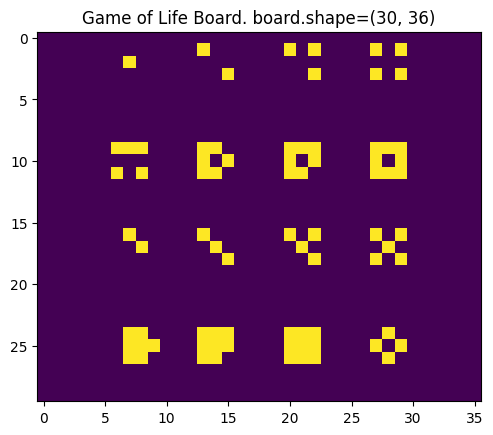

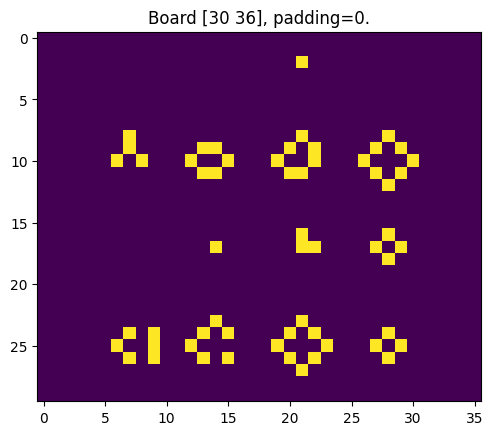

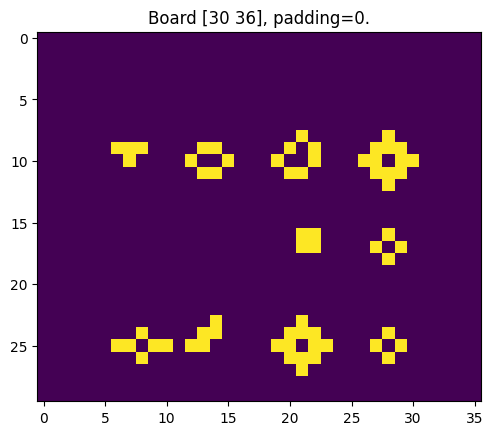

In [ ]:
X_test = load_board(sheet_name='Test_Board5', show=True)
y_test = play(X_test)
y_test2 = play_n_steps(X_test, 2, show=True)

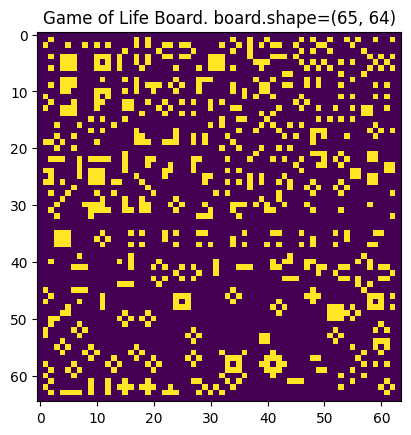

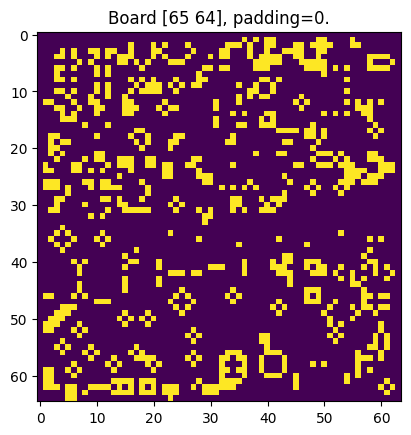

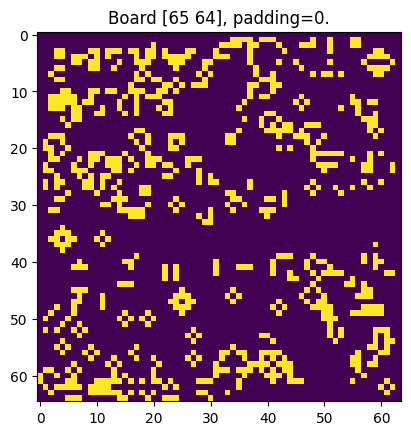

In [ ]:
X_train = load_board(sheet_name='Training_Board11', show=True)
y_train2 = play_n_steps(X_train, 2, show=True)
X_train_ready = np.array(X_train)[None, ..., None]
y_train2_ready = np.array(y_train2)[None, ...]

In [ ]:
from google.colab import output
beep = "https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg"

In [ ]:
# @title Minimal model with fixed init
def get_minimal_model(seed):
  tf.random.set_seed(seed)

  n_steps = 2
  n_filters = 2
  kernel_size = (3, 3)
  input_shape = (None, None, 1)

  input_layer = tf.keras.layers.Input(shape=input_shape)

  conv2d_layer = tf.keras.layers.Conv2D(
      filters=n_filters,
      kernel_size=kernel_size,
      activation='tanh',
      use_bias=True,
      padding='same',
      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed),
      )(input_layer)

  output_layer = tf.keras.layers.Conv2D(
      filters=1,
      kernel_size=(1, 1),
      use_bias=True,
      activation='relu',
      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed),
      )(conv2d_layer)

  model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

  tf.keras.utils.plot_model(model)
  return model

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

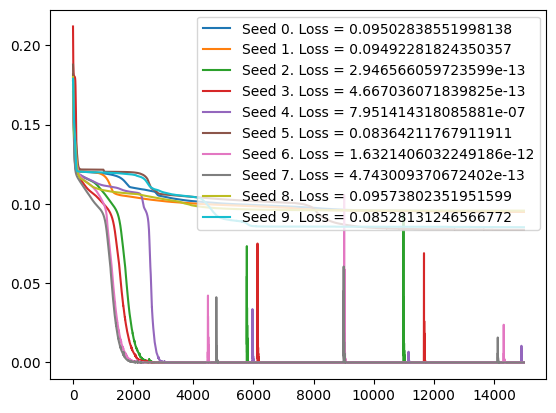

In [ ]:
losses = {}
models = {}
for seed in range(10):
  tf.random.set_seed(seed)
  models[seed] = get_minimal_model(seed)
  recursive_model = RecursiveModel(core_model=models[seed], n_times=2)
  adam = tf.keras.optimizers.Adam(learning_rate=0.0025)
  recursive_model.compile(optimizer=adam, loss='mse')

  history = recursive_model.fit(
      X_train_ready,
      y_train2_ready,
      epochs=15000,
      batch_size=1,
      verbose=False,
      callbacks=[TqdmCallback(verbose=True)]
  )

  loss = history.history['loss']
  losses[seed] = loss
  label = f'Seed {seed}. Loss = {loss[-1]}'
  plt.plot(loss, label=label)
plt.legend()
plt.show()

1/1 [==============================] - 0s 84ms/step


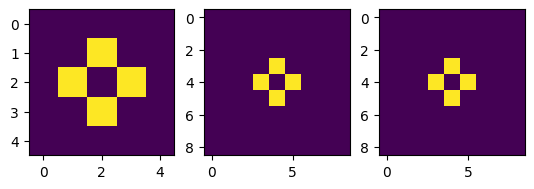

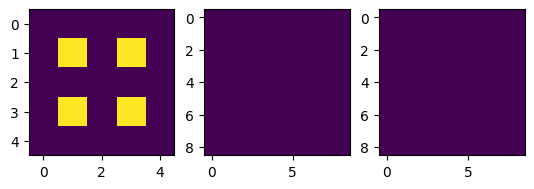

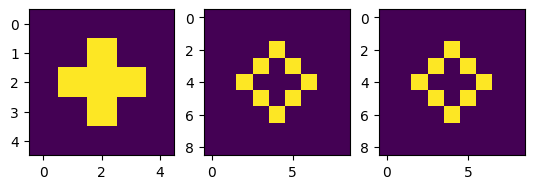

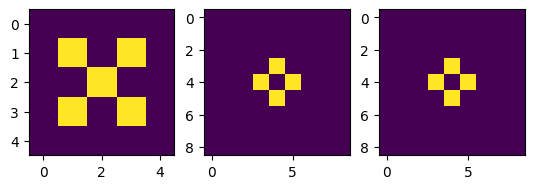

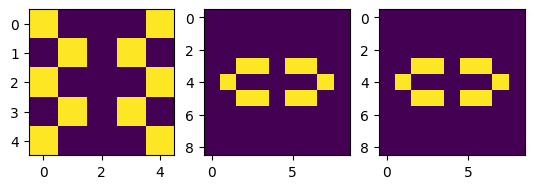

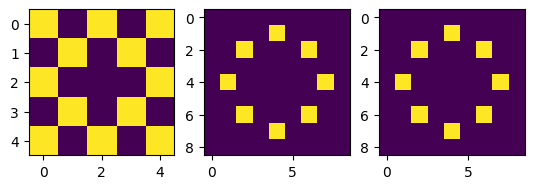

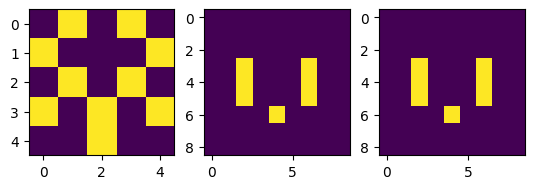

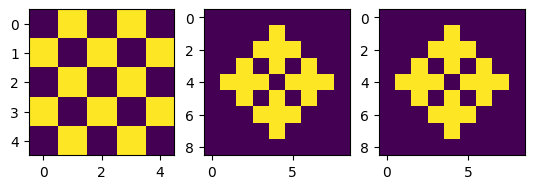

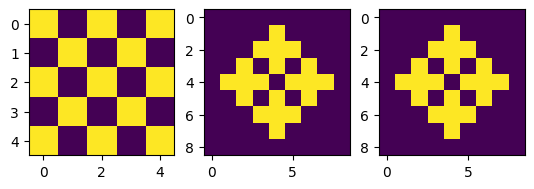

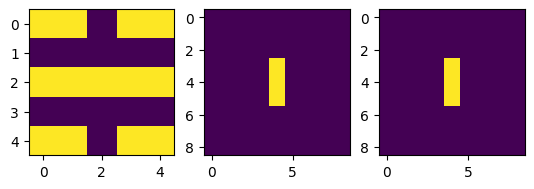

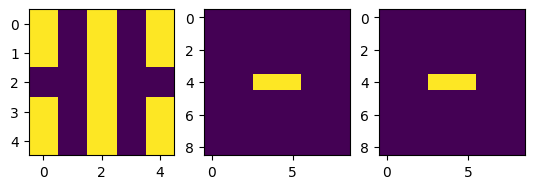

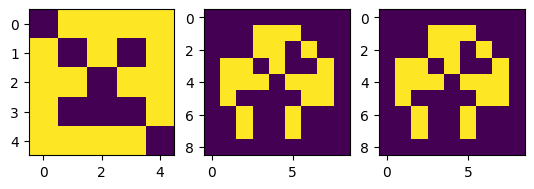

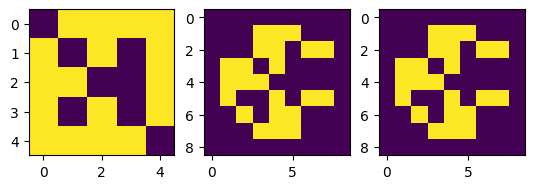

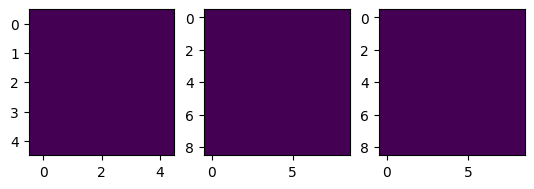

In [ ]:
X_check, y_check, X_check_ready, y_check_ready = compose_data(
    n_steps=2,
    shuffle=False
    )
y_check_pred = RecursiveModel(models[7], 2).predict(X_check_ready[..., None])
for xti, yti, ytpi in zip(X_check, y_check, y_check_pred):
  fig, axes = plt.subplots(1,3)
  axes[0].imshow(xti)
  axes[1].imshow(yti)
  axes[2].imshow(ytpi)
  plt.show()

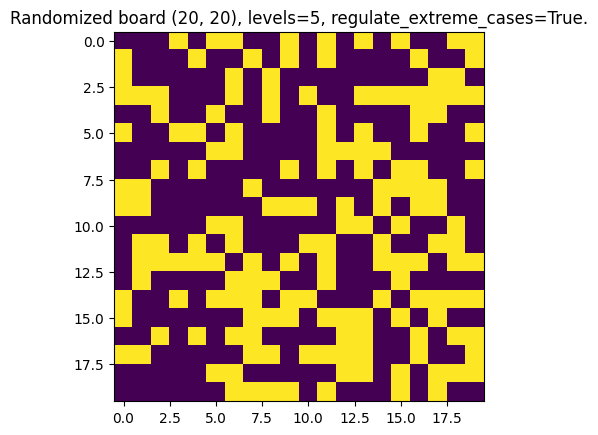

In [ ]:
X_test = generate_board((20, 20), show=True, regulate_extreme_cases=True)

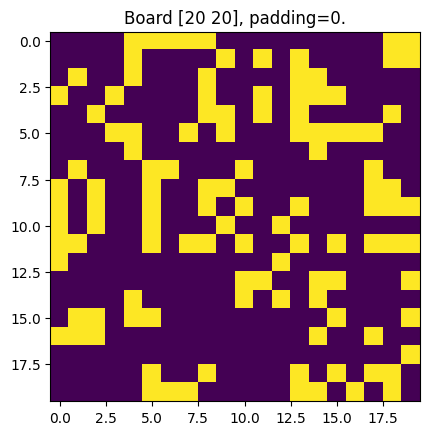

1/1 [==============================] - 0s 75ms/step


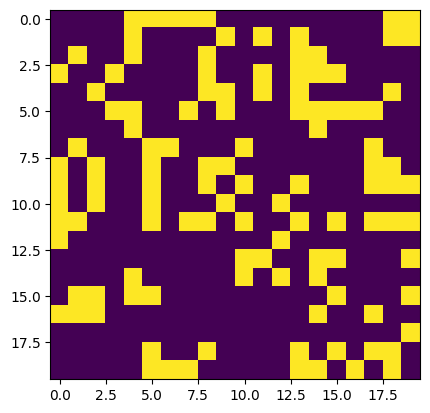

In [ ]:
y_test = play(play(X_test), show=True)
y_pred = RecursiveModel(models[7], 2).predict(np.array(X_test)[None, ..., None])
y_pred = y_pred.squeeze()  # y_pred.reshape(X_test.shape[0], X_test.shape[1])
plt.imshow(y_pred)

## 2-Step Board 10: x2 tanh-ReLU Conv Minimal

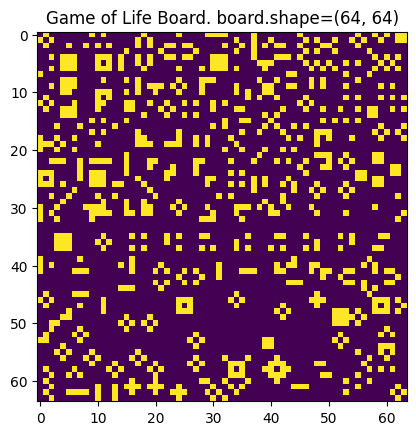

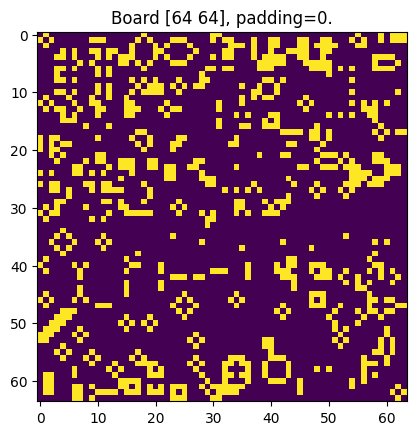

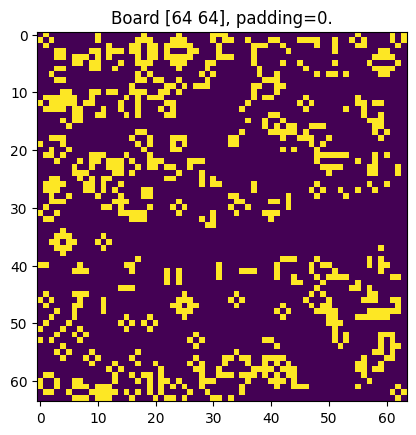

In [ ]:
X_train = load_board(sheet_name='Training_Board10', show=True)
y_train2 = play_n_steps(X_train, 2, show=True)
X_train_ready = np.array(X_train)[None, ..., None]
y_train2_ready = np.array(y_train2)[None, ...]

In [ ]:
from google.colab import output
beep = "https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg"

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

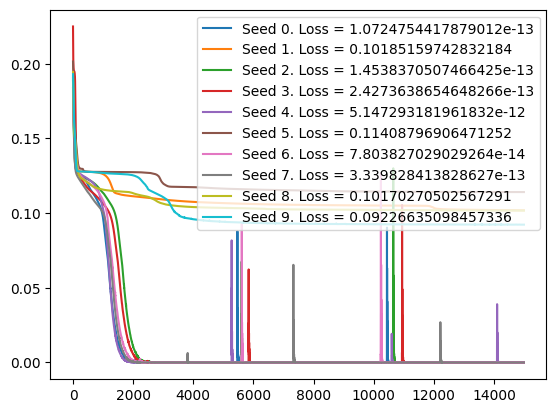

In [ ]:
losses = {}
models = {}
for seed in range(10):
  tf.random.set_seed(seed)
  models[seed] = get_minimal_model(seed)
  recursive_model = RecursiveModel(core_model=models[seed], n_times=2)
  adam = tf.keras.optimizers.Adam(learning_rate=0.0025)
  recursive_model.compile(optimizer=adam, loss='mse')

  history = recursive_model.fit(
      X_train_ready,
      y_train2_ready,
      epochs=15000,
      batch_size=1,
      verbose=False,
      callbacks=[TqdmCallback(verbose=True)]
  )

  loss = history.history['loss']
  losses[seed] = loss
  label = f'Seed {seed}. Loss = {loss[-1]}'
  plt.plot(loss, label=label)
plt.legend()
plt.show()

1/1 [==============================] - 0s 126ms/step


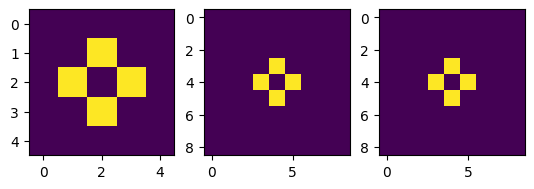

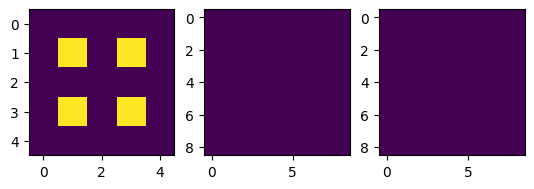

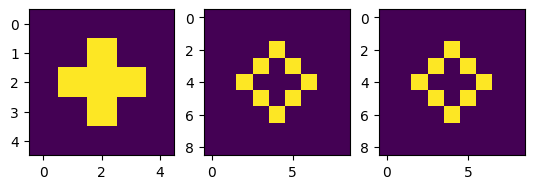

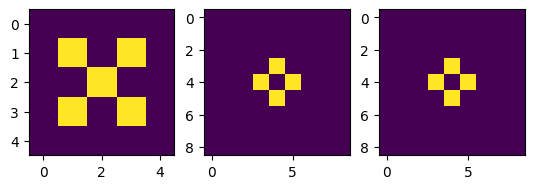

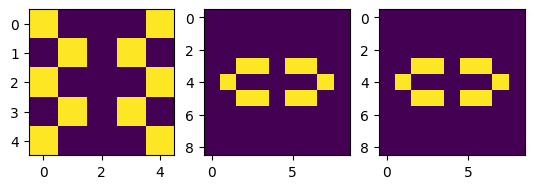

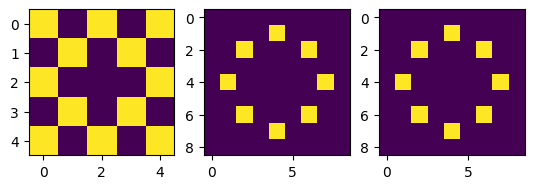

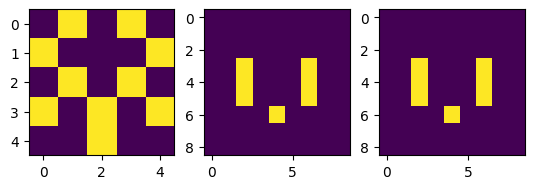

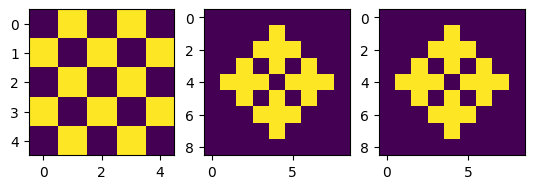

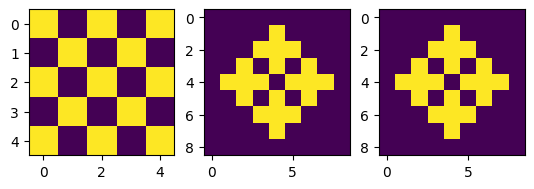

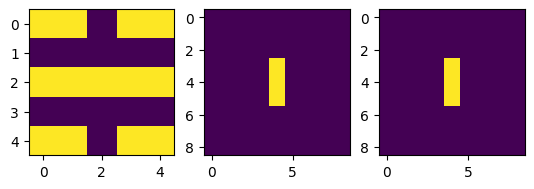

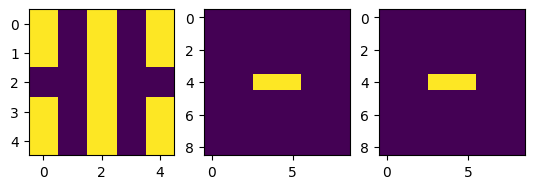

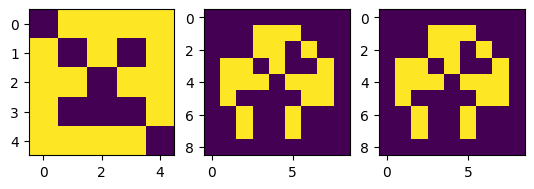

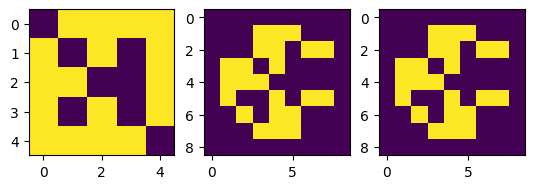

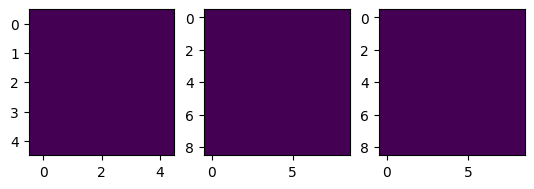

In [ ]:
X_check, y_check, X_check_ready, y_check_ready = Xy_from_preset_5x5_patches(
    n_steps=2,
    shuffle=False
    )
y_check_pred = RecursiveModel(models[7], 2).predict(X_check_ready[..., None])
for xti, yti, ytpi in zip(X_check, y_check, y_check_pred):
  fig, axes = plt.subplots(1,3)
  axes[0].imshow(xti)
  axes[1].imshow(yti)
  axes[2].imshow(ytpi)
  plt.show()

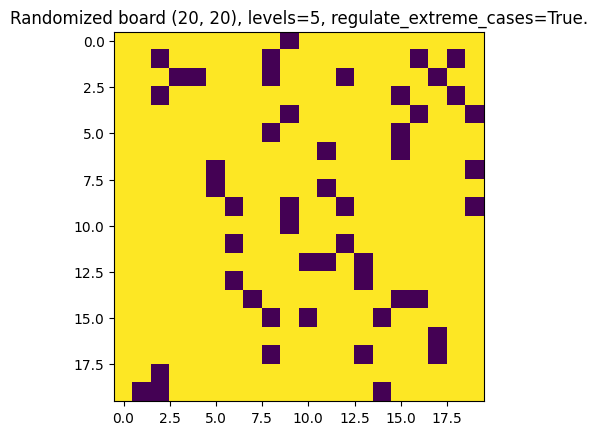

In [ ]:
X_test = generate_board((20, 20), show=True, regulate_extreme_cases=True)

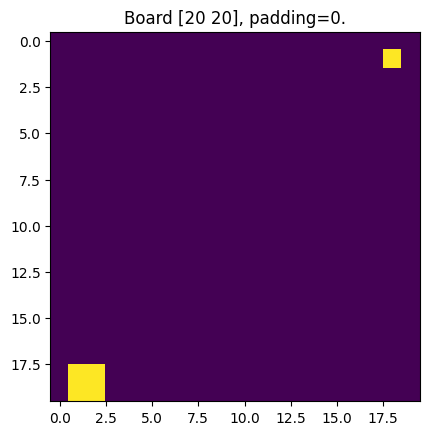

1/1 [==============================] - 0s 58ms/step


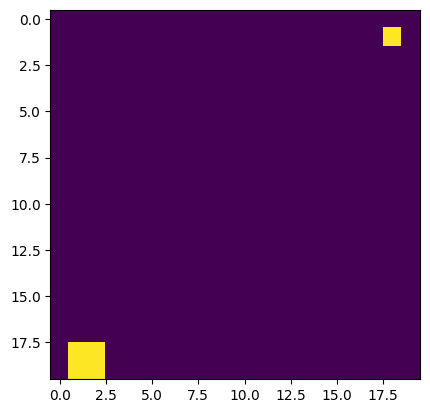

In [ ]:
y_test = play(play(X_test), show=True)
y_pred = RecursiveModel(models[7], 2).predict(np.array(X_test)[None, ..., None])
y_pred = y_pred.squeeze()  # y_pred.reshape(X_test.shape[0], X_test.shape[1])
plt.imshow(y_pred)

## 1-Step Board 10: x2 tanh-ReLU Conv Minimal

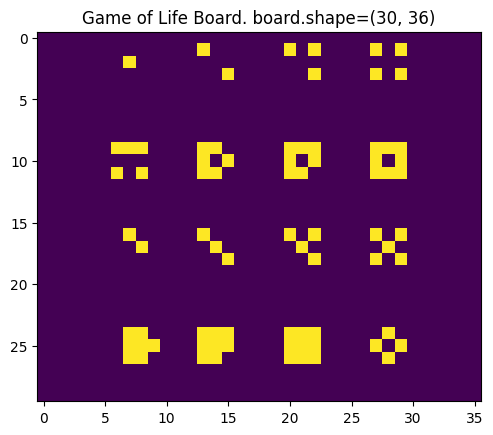

In [2]:
X_test = load_board(sheet_name='Test_Board5', show=True)
y_test = play(X_test)

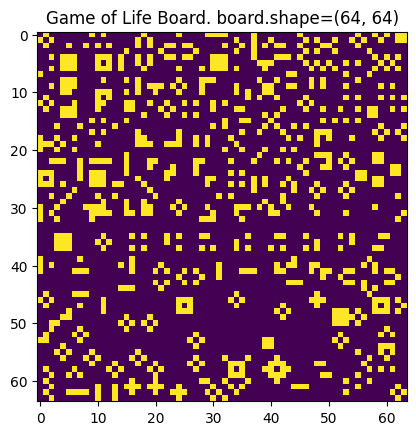

In [6]:
board_name = 'Training_Board10'
X_train = load_board(sheet_name=board_name, show=True)
y_train = play(X_train)
X_train_ready = np.array(X_train)[None, ..., None]
y_train_ready = np.array(y_train)[None, ...]

In [ ]:
from google.colab import output
beep = "https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg"

In [5]:
# @title Minimal model with fixed init
def get_minimal_model(seed):
  tf.random.set_seed(seed)

  n_steps = 1
  n_filters = 2
  kernel_size = (3, 3)
  input_shape = (None, None, 1)

  input_layer = tf.keras.layers.Input(shape=input_shape)

  conv2d_layer = tf.keras.layers.Conv2D(
      filters=n_filters,
      kernel_size=kernel_size,
      activation='tanh',
      use_bias=True,
      padding='same',
      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed),
      )(input_layer)

  output_layer = tf.keras.layers.Conv2D(
      filters=1,
      kernel_size=(1, 1),
      use_bias=True,
      activation='relu',
      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed),
      )(conv2d_layer)

  model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

  tf.keras.utils.plot_model(model)
  return model

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

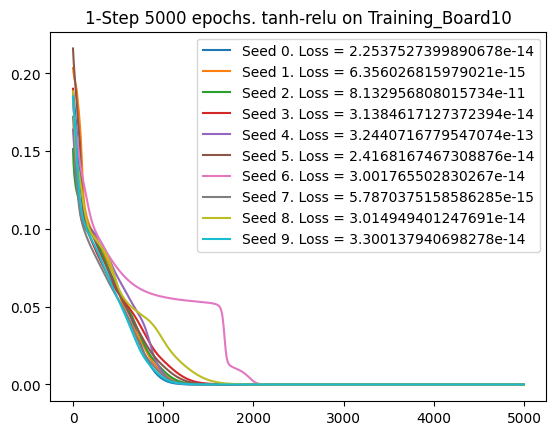

In [8]:
losses = {}
models = {}
EPOCHS = 5000
for seed in range(10):
  tf.random.set_seed(seed)
  model = get_minimal_model(seed)
  models[seed] = model
  adam = tf.keras.optimizers.Adam(learning_rate=0.0025)
  model.compile(optimizer=adam, loss='mse')

  history = model.fit(
      X_train_ready,
      y_train_ready,
      epochs=EPOCHS,
      batch_size=1,
      verbose=False,
      callbacks=[TqdmCallback(verbose=True)]
  )

  loss = history.history['loss']
  losses[seed] = loss
  label = f'Seed {seed}. Loss = {loss[-1]}'
  plt.plot(loss, label=label)

plt.title(f'1-Step {EPOCHS} epochs. tanh-relu on {board_name}')
plt.legend()
plt.show()

1/1 [==============================] - 0s 71ms/step


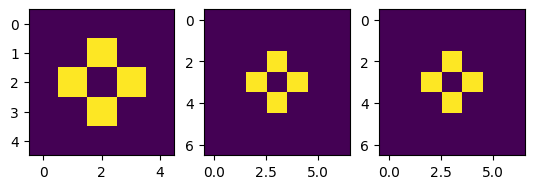

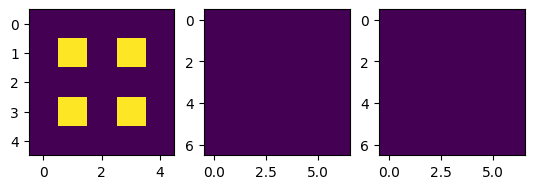

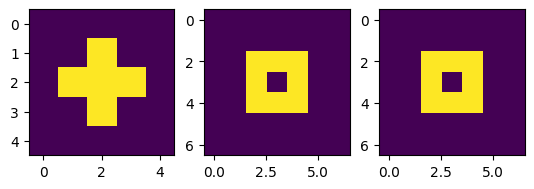

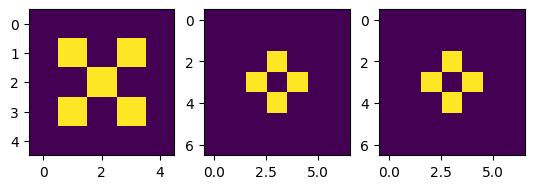

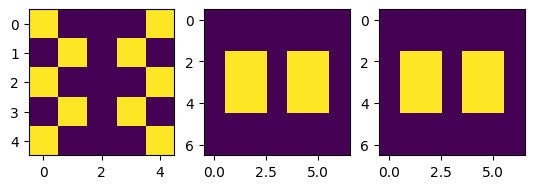

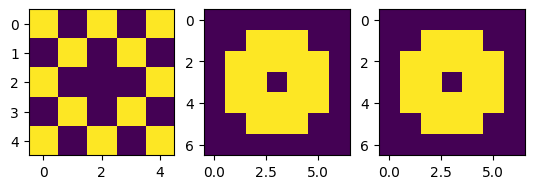

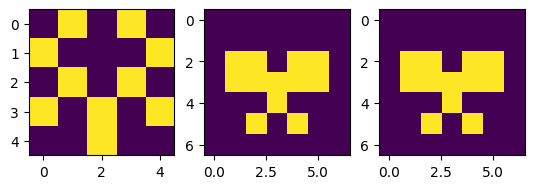

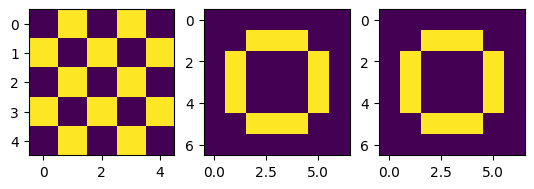

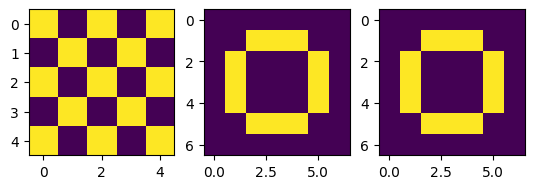

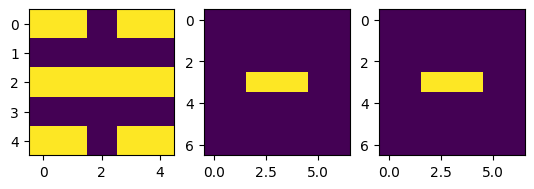

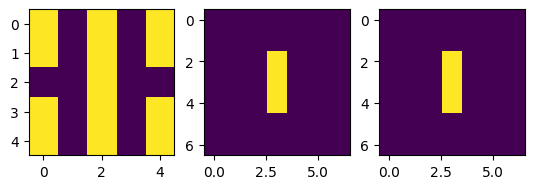

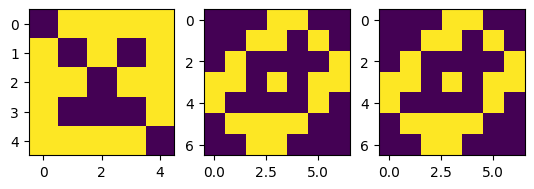

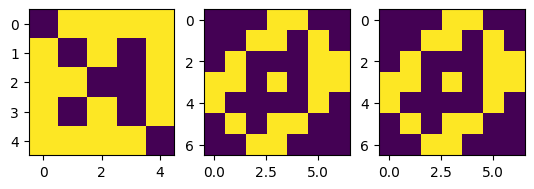

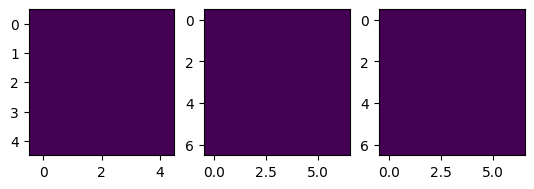

In [31]:
# @title Check a model on patches
N_STEPS = 1
X_check, y_check, X_check_ready, y_check_ready = Xy_from_preset_5x5_patches(
    n_steps=N_STEPS,
    shuffle=False
    )
y_check_pred = RecursiveModel(models[0], N_STEPS).predict(X_check_ready[..., None])
for xti, yti, ytpi in zip(X_check, y_check, y_check_pred):
  fig, axes = plt.subplots(1,3)
  axes[0].imshow(xti)
  axes[1].imshow(yti)
  axes[2].imshow(ytpi)
  plt.show()

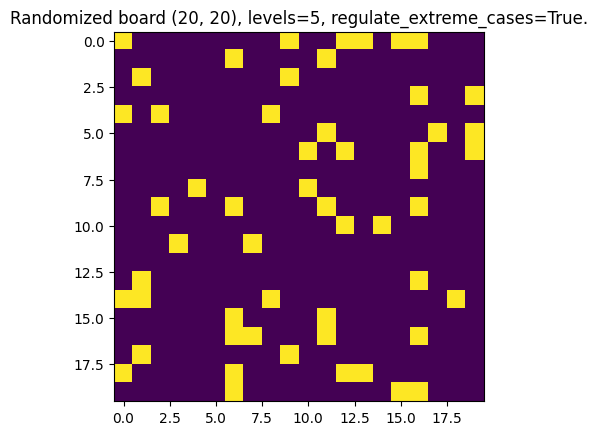

In [24]:
X_test = generate_board((20, 20), show=True, regulate_extreme_cases=True)

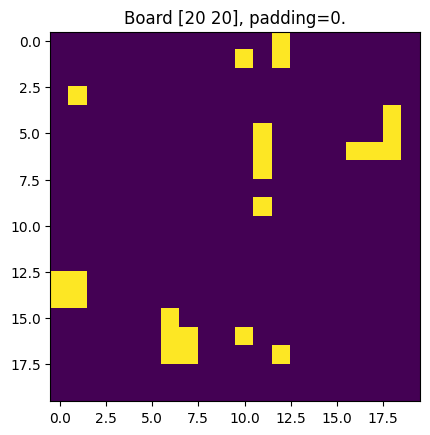

1/1 [==============================] - 0s 117ms/step


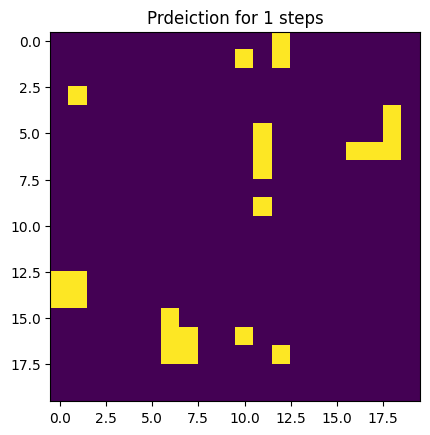

In [29]:
N_STEPS = 1
y_test = play_n_steps(X_test, N_STEPS, show=True)
y_pred = RecursiveModel(models[0], N_STEPS).predict(np.array(X_test)[None, ..., None])
y_pred = y_pred.squeeze()  # y_pred.reshape(X_test.shape[0], X_test.shape[1])
plt.title(f'Prdeiction for {N_STEPS} steps')
plt.imshow(y_pred)


## 1-Step Board 10: x2 tanh-ReLU Conv Minimal (Larger Test)

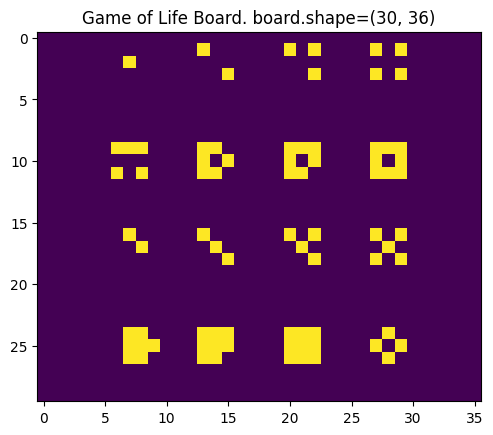

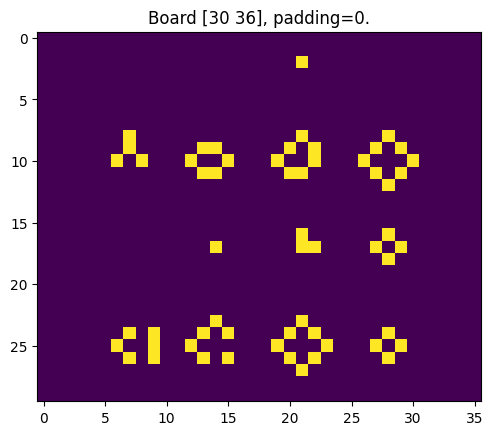

In [33]:
X_test = load_board(sheet_name='Test_Board5', show=True)
y_test = play(X_test, show=True)

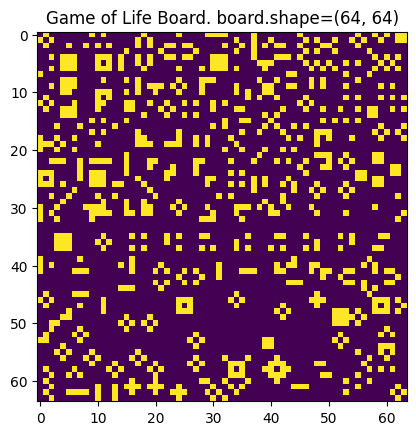

In [34]:
board_name = 'Training_Board10'
X_train = load_board(sheet_name=board_name, show=True)
y_train = play(X_train)
X_train_ready = np.array(X_train)[None, ..., None]
y_train_ready = np.array(y_train)[None, ...]

In [35]:
# @title Minimal model with fixed init
def get_minimal_model(seed):
  tf.random.set_seed(seed)

  n_steps = 1
  n_filters = 2
  kernel_size = (3, 3)
  input_shape = (None, None, 1)

  input_layer = tf.keras.layers.Input(shape=input_shape)

  conv2d_layer = tf.keras.layers.Conv2D(
      filters=n_filters,
      kernel_size=kernel_size,
      activation='tanh',
      use_bias=True,
      padding='same',
      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed),
      )(input_layer)

  output_layer = tf.keras.layers.Conv2D(
      filters=1,
      kernel_size=(1, 1),
      use_bias=True,
      activation='relu',
      kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed),
      )(conv2d_layer)

  model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

  tf.keras.utils.plot_model(model)
  return model

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

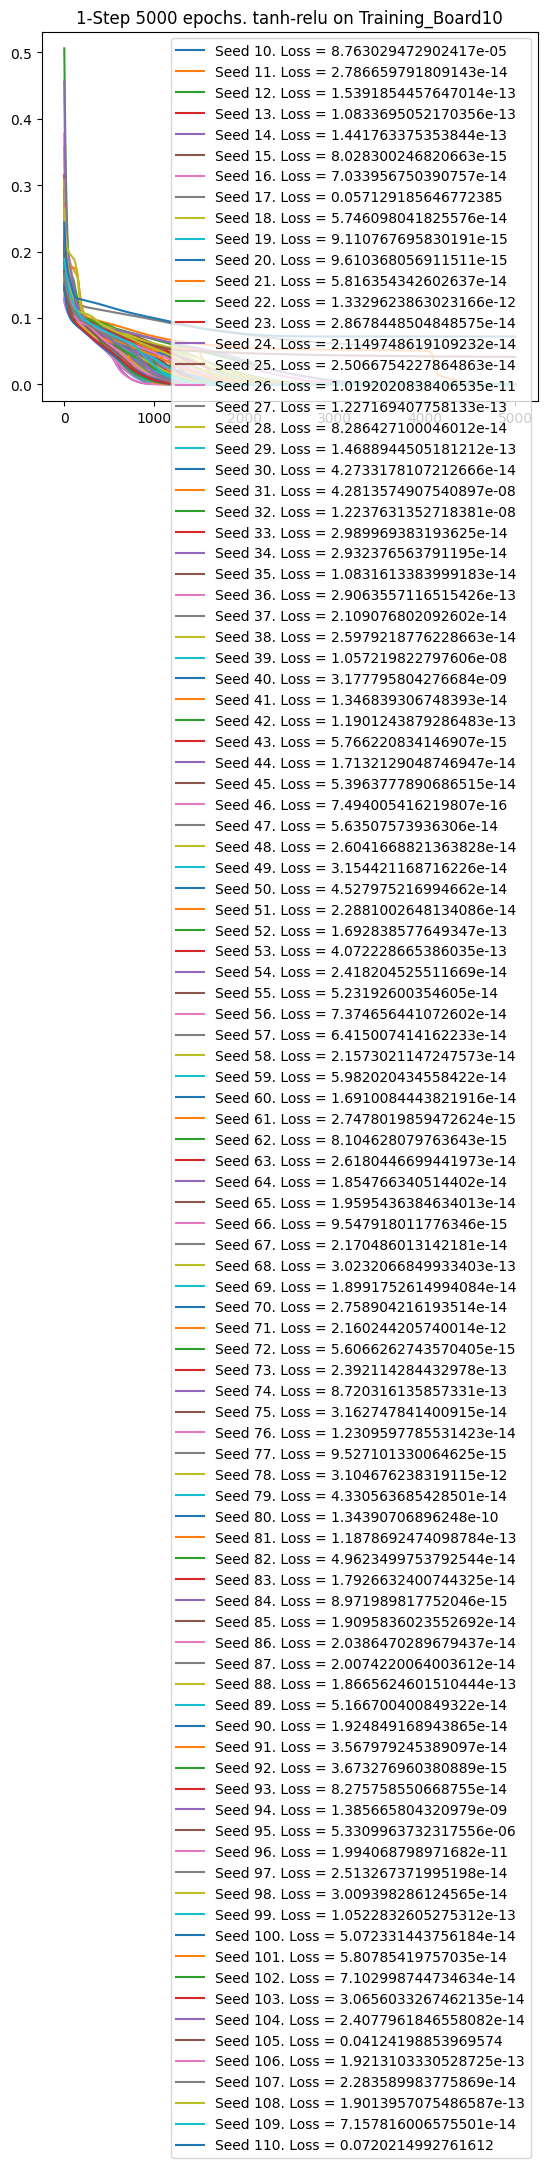

In [37]:
losses = {}
models = {}
EPOCHS = 5000
for seed in range(10, 111):
  tf.random.set_seed(seed)
  model = get_minimal_model(seed)
  models[seed] = model
  adam = tf.keras.optimizers.Adam(learning_rate=0.0025)
  model.compile(optimizer=adam, loss='mse')

  history = model.fit(
      X_train_ready,
      y_train_ready,
      epochs=EPOCHS,
      batch_size=1,
      verbose=False,
      callbacks=[TqdmCallback(verbose=True)]
  )

  loss = history.history['loss']
  losses[seed] = loss
  label = f'Seed {seed}. Loss = {loss[-1]}'
  plt.plot(loss, label=label)

plt.title(f'1-Step {EPOCHS} epochs. tanh-relu on {board_name}')
plt.legend()
plt.show()

1/1 [==============================] - 0s 215ms/step


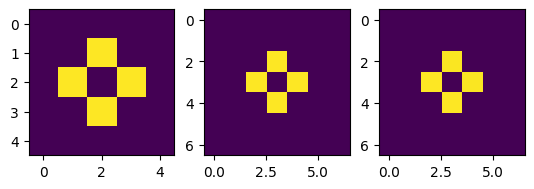

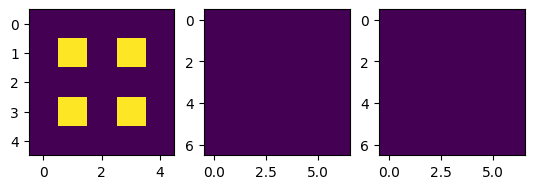

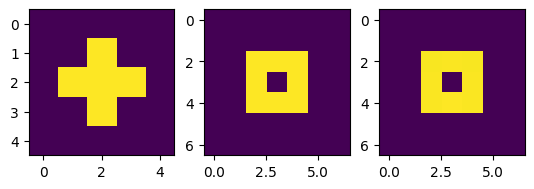

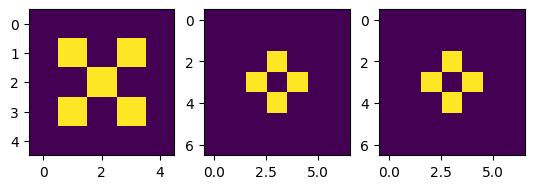

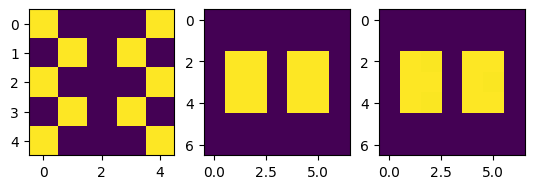

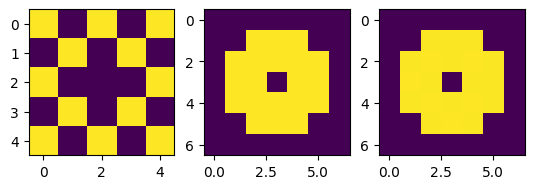

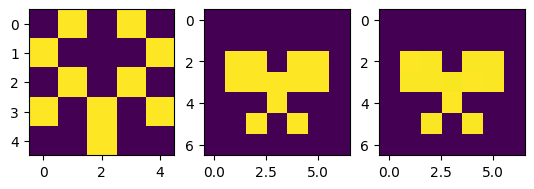

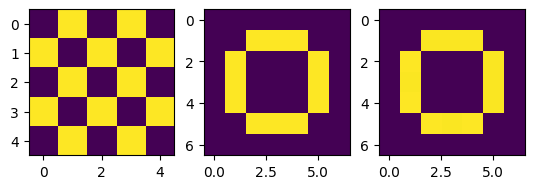

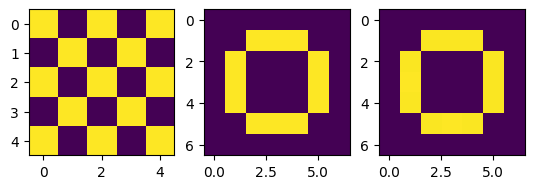

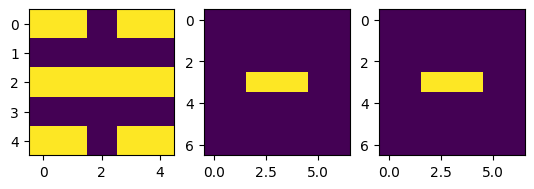

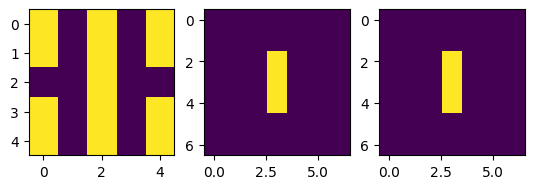

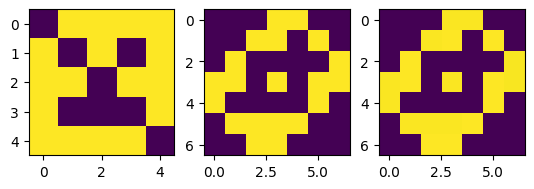

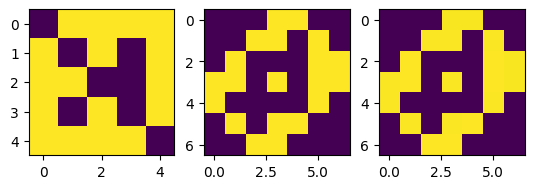

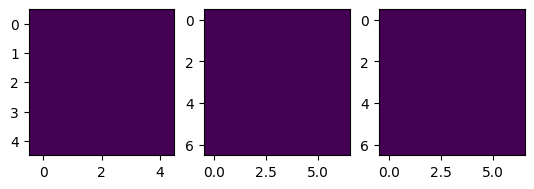

In [39]:
# @title Check a model on patches
N_STEPS = 1
X_check, y_check, X_check_ready, y_check_ready = Xy_from_preset_5x5_patches(
    n_steps=N_STEPS,
    shuffle=False
    )
y_check_pred = RecursiveModel(list(models.values())


 [0], N_STEPS)\
.predict(X_check_ready[..., None])
for xti, yti, ytpi in zip(X_check, y_check, y_check_pred):
  fig, axes = plt.subplots(1,3)
  axes[0].imshow(xti)
  axes[1].imshow(yti)
  axes[2].imshow(ytpi)
  plt.show()

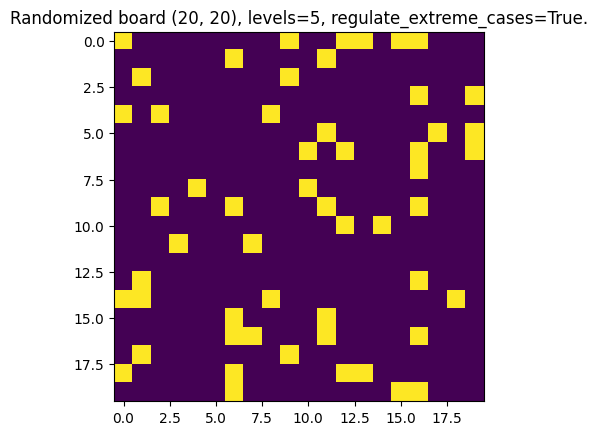

In [ ]:
X_test = generate_board((20, 20), show=True, regulate_extreme_cases=True)

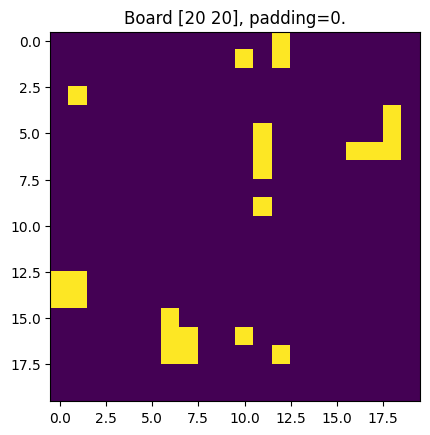

1/1 [==============================] - 0s 117ms/step


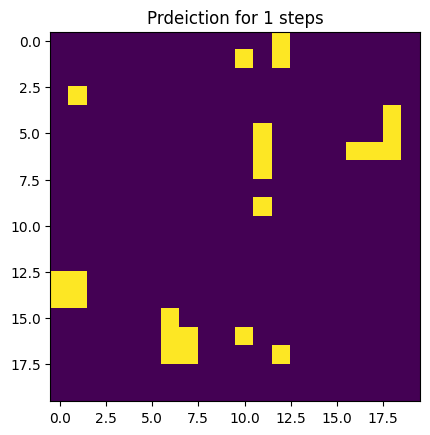

In [ ]:
N_STEPS = 1
y_test = play_n_steps(X_test, N_STEPS, show=True)
y_pred = RecursiveModel(models[0], N_STEPS).predict(np.array(X_test)[None, ..., None])
y_pred = y_pred.squeeze()  # y_pred.reshape(X_test.shape[0], X_test.shape[1])
plt.title(f'Prdeiction for {N_STEPS} steps')
plt.imshow(y_pred)


## 2-Step Board 11: x2 tanh-ReLU Conv Minimal

In [2]:
N_STEPS = 2

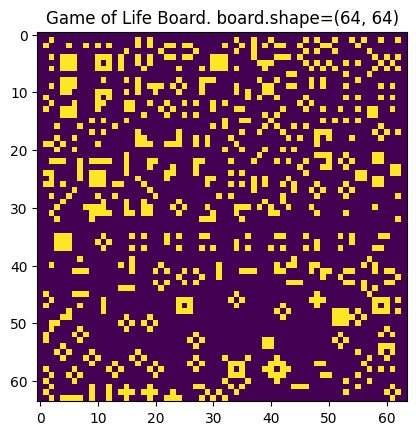

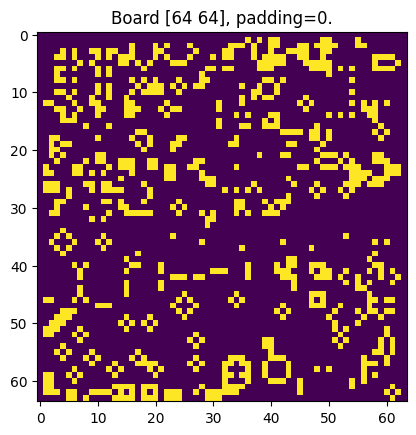

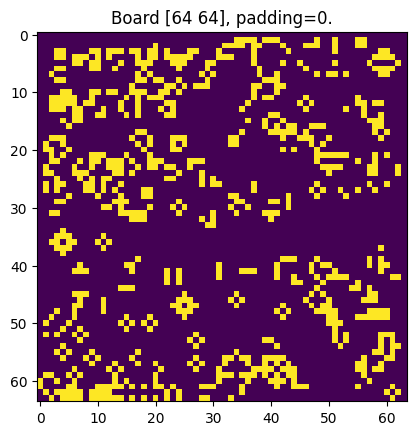

In [3]:
board_name = 'Training_Board11'
X_train = load_board(sheet_name=board_name, show=True)
y_train = play_n_steps(X_train, N_STEPS, show=True)
X_train_ready = np.array(X_train)[None, ..., None]
y_train_ready = np.array(y_train)[None, ...]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

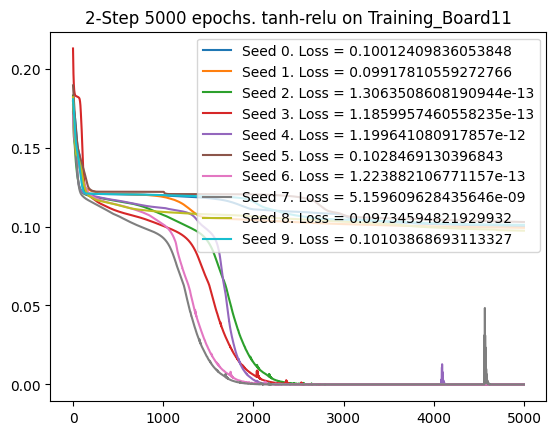

In [5]:
losses = {}
models = {}
EPOCHS = 5000
for seed in range(10):
  tf.random.set_seed(seed)
  model = get_minimal_model(seed)
  models[seed] = model
  recursive_model = RecursiveModel(core_model=model, n_times=N_STEPS)
  adam = tf.keras.optimizers.Adam(learning_rate=0.0025)
  recursive_model.compile(optimizer=adam, loss='mse')

  history = recursive_model.fit(
      X_train_ready,
      y_train_ready,
      epochs=EPOCHS,
      batch_size=1,
      verbose=False,
      callbacks=[TqdmCallback(verbose=True)]
  )

  loss = history.history['loss']
  losses[seed] = loss
  label = f'Seed {seed}. Loss = {loss[-1]}'
  plt.plot(loss, label=label)

plt.title(f'2-Step {EPOCHS} epochs. tanh-relu on {board_name}')
plt.legend()
plt.show()

1/1 [==============================] - 0s 92ms/step


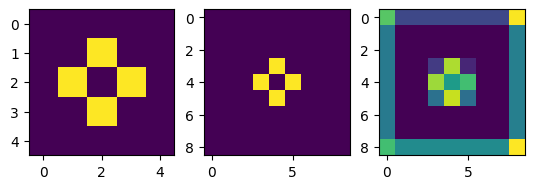

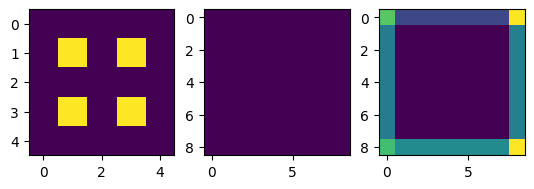

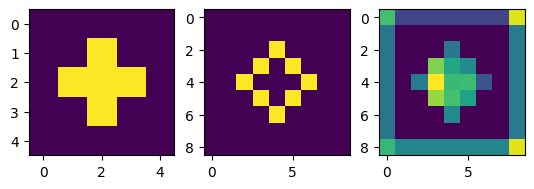

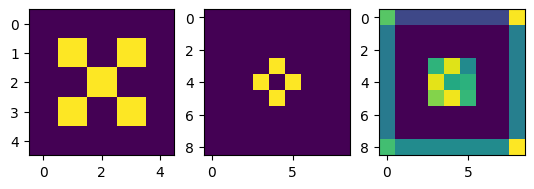

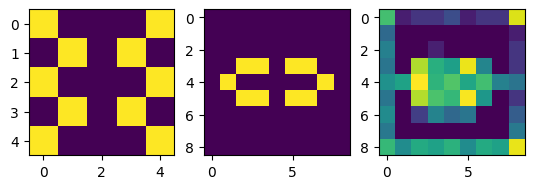

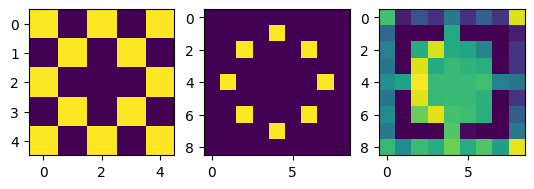

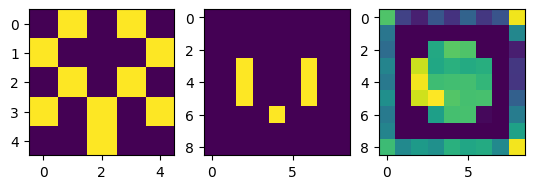

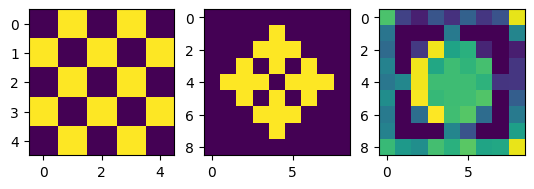

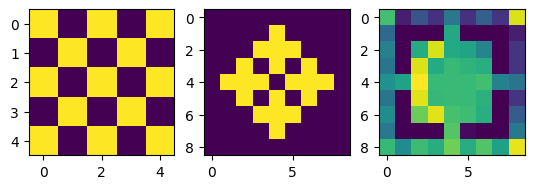

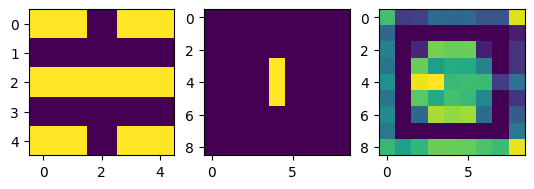

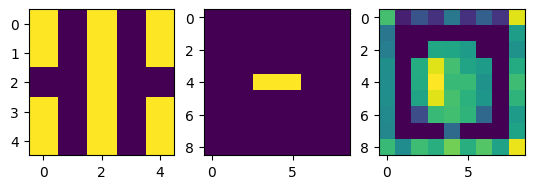

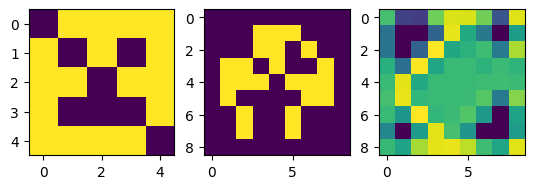

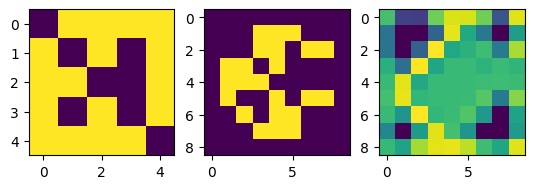

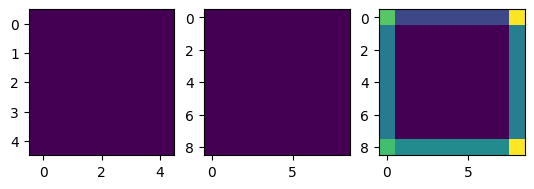

In [6]:
# @title Check a model on patches
N_STEPS = 2
X_check, y_check, X_check_ready, y_check_ready = Xy_from_preset_5x5_patches(
    n_steps=N_STEPS,
    shuffle=False
    )
y_check_pred = RecursiveModel(models[0], N_STEPS)\
.predict(X_check_ready[..., None])
for xti, yti, ytpi in zip(X_check, y_check, y_check_pred):
  fig, axes = plt.subplots(1,3)
  axes[0].imshow(xti)
  axes[1].imshow(yti)
  axes[2].imshow(ytpi)
  plt.show()

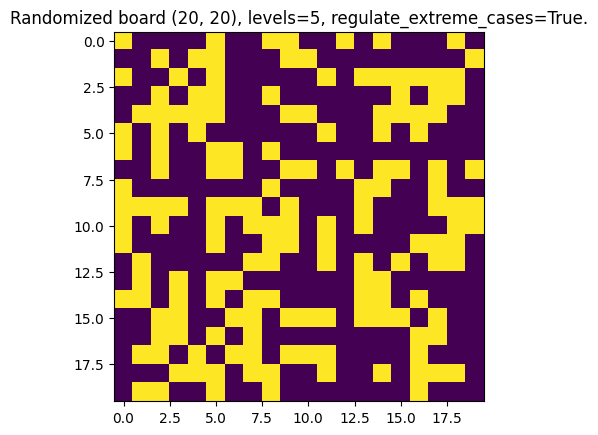

In [8]:
X_test = generate_board((20, 20), show=True, regulate_extreme_cases=True)

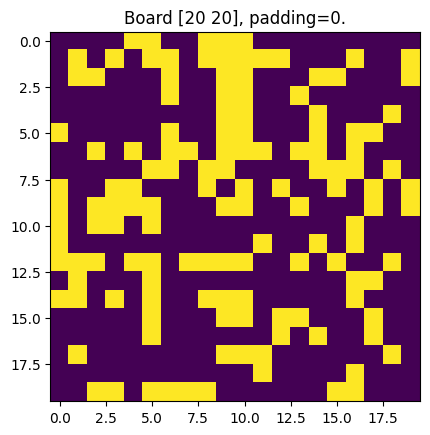

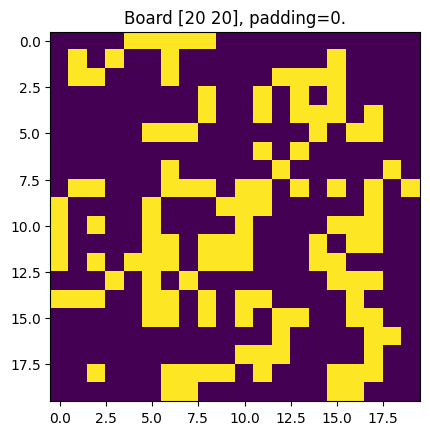

1/1 [==============================] - 0s 70ms/step


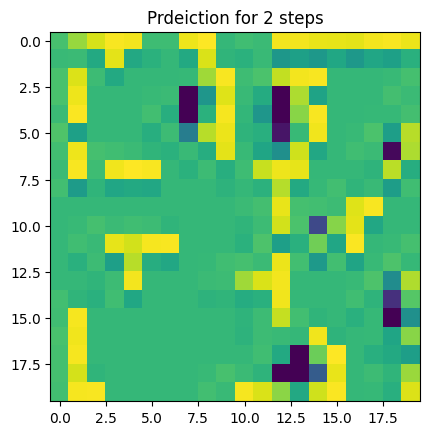

In [13]:
SEED = 0
y_test = play_n_steps(X_test, N_STEPS, show=True)
y_pred = RecursiveModel(models[SEED], N_STEPS).predict(np.array(X_test)[None, ..., None])
y_pred = y_pred.squeeze()  # y_pred.reshape(X_test.shape[0], X_test.shape[1])
plt.title(f'Prdeiction for {N_STEPS} steps')
plt.imshow(y_pred)

In [14]:
for seed, model in models.items():
    filename = f'models/{N_STEPS}_steps_{board_name}_seed_{seed}.hdf5'
    model.save(filename)

c:\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 2-Step Board 10: x2 tanh-ReLU Conv Minimal (test bad seeds)

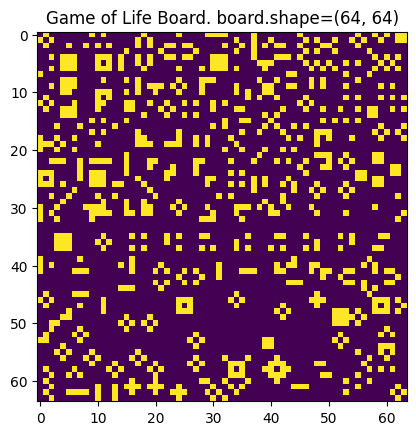

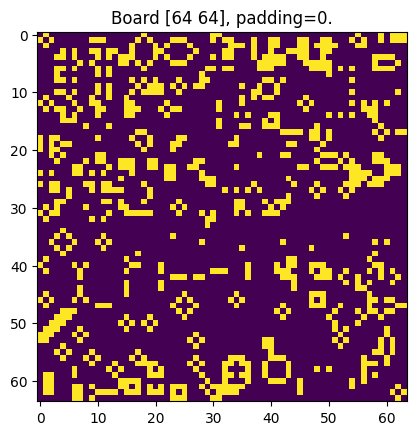

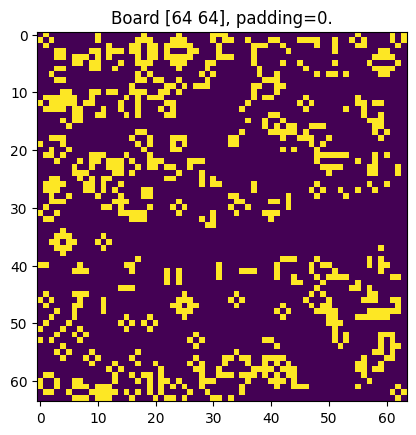

In [39]:
N_STEPS = 2
BOARD_NAME = 'Training_Board_10'
results[N_STEPS] = {}
results[N_STEPS][BOARD_NAME] = {}
X_train = load_board(sheet_name=BOARD_NAME, show=True)
y_train = play_n_steps(X_train, N_STEPS, show=True)
X_train_ready = np.array(X_train)[None, ..., None]
y_train_ready = np.array(y_train)[None, ...]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

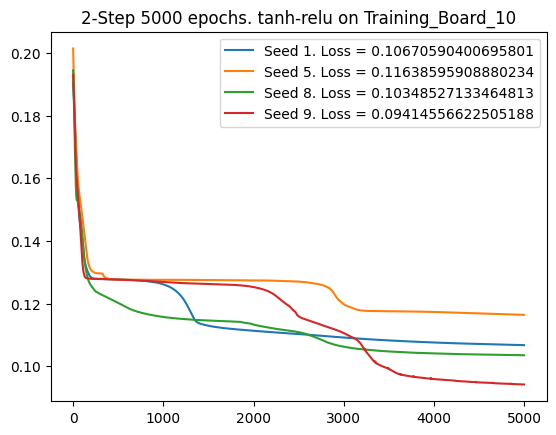

In [40]:
EPOCHS = 5000
for seed in [1, 5, 8, 9]:
  results[N_STEPS][BOARD_NAME][seed] = {}
  tf.random.set_seed(seed)
  model = get_minimal_model(seed)
  model_name = f'{N_STEPS}_steps_{BOARD_NAME}_seed_{seed}' 
  results[N_STEPS][BOARD_NAME][seed]['model'] = model
  recursive_model = RecursiveModel(core_model=model, n_times=N_STEPS)
  adam = tf.keras.optimizers.Adam(learning_rate=0.0025)
  model.compile(optimizer=adam, loss='mse')
  recursive_model.compile(optimizer=adam, loss='mse')

  history = recursive_model.fit(
      X_train_ready,
      y_train_ready,
      epochs=EPOCHS,
      batch_size=1,
      verbose=False,
      callbacks=[
        cpt(model_name),
        TqdmCallback(verbose=True)
        ]
  )
  # model.save(f'models/{model_name}.hdf5')
  loss = history.history['loss']
  results[N_STEPS][BOARD_NAME][seed]['loss'] = loss
  label = f'Seed {seed}. Loss = {loss[-1]}'
  plt.plot(loss, label=label)

plt.title(f'{N_STEPS}-Step {EPOCHS} epochs. tanh-relu on {BOARD_NAME}')
plt.legend()
plt.show()

1/1 [==============================] - 0s 88ms/step


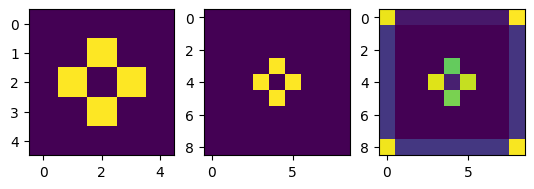

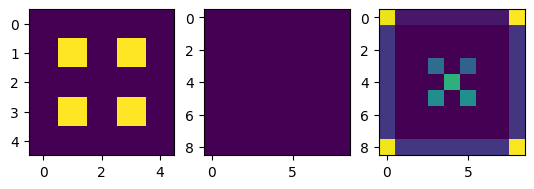

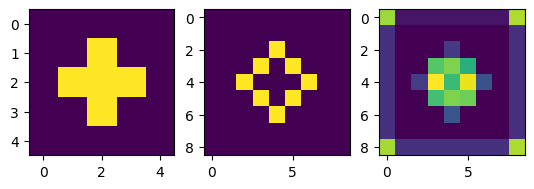

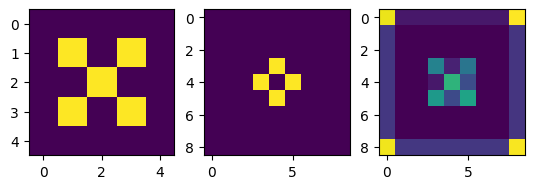

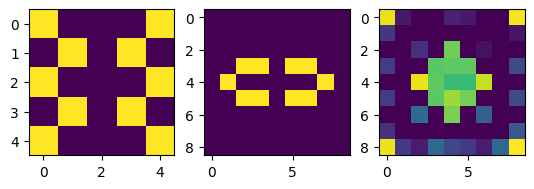

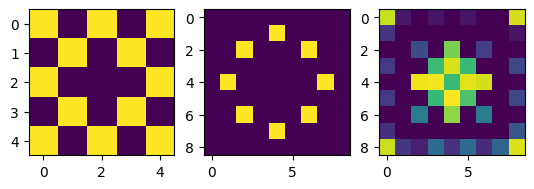

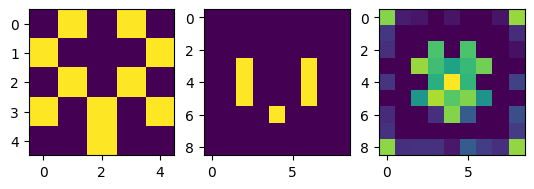

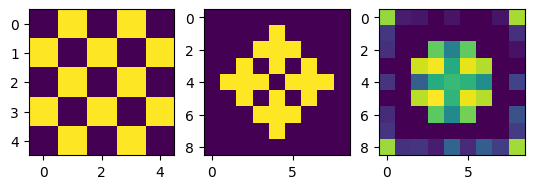

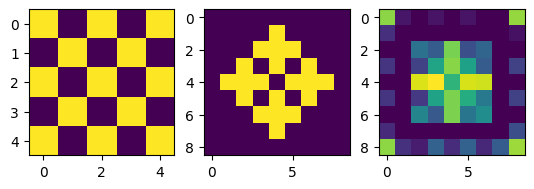

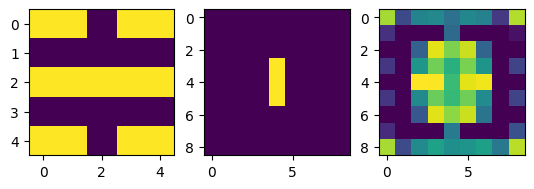

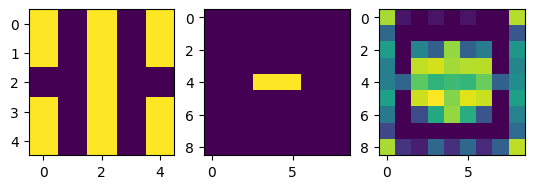

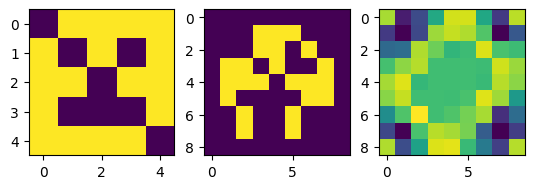

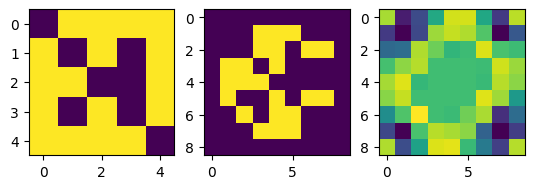

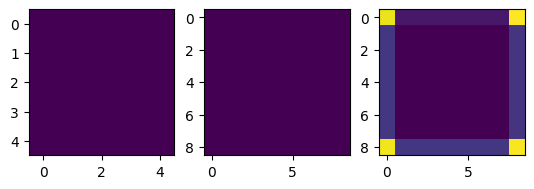

In [42]:
# @title Check a model on patches
SEED = 5
X_check, y_check, X_check_ready, y_check_ready = Xy_from_preset_5x5_patches(
    n_steps=N_STEPS,
    shuffle=False
    )
y_check_pred = RecursiveModel(results[N_STEPS][BOARD_NAME][SEED]['model'], N_STEPS)\
.predict(X_check_ready[..., None])
for xti, yti, ytpi in zip(X_check, y_check, y_check_pred):
  fig, axes = plt.subplots(1,3)
  axes[0].imshow(xti)
  axes[1].imshow(yti)
  axes[2].imshow(ytpi)
  plt.show()

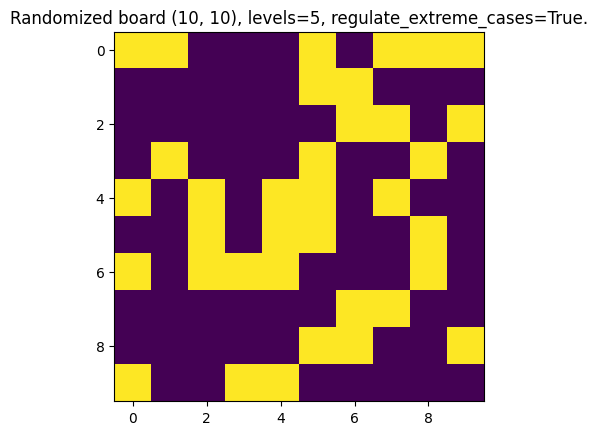

In [44]:
X_test = generate_board((10, 10), show=True, regulate_extreme_cases=True)

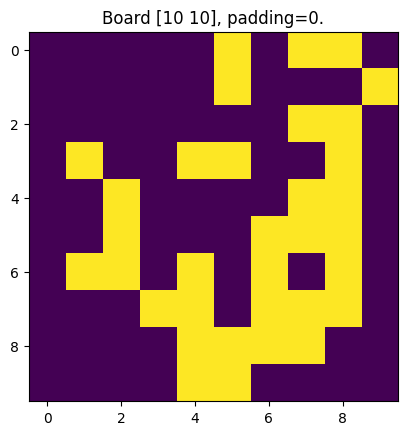

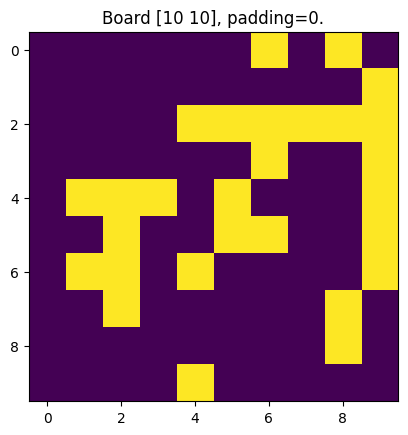

1/1 [==============================] - 0s 64ms/step


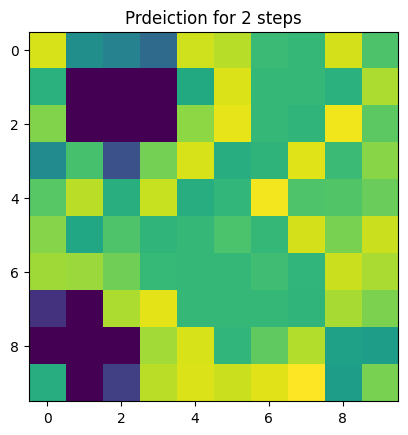

In [45]:
y_test = play_n_steps(X_test, N_STEPS, show=True)
y_pred = RecursiveModel(results[N_STEPS][BOARD_NAME][SEED]['model'], N_STEPS)\
    .predict(np.array(X_test)[None, ..., None])
y_pred = y_pred.squeeze()  # y_pred.reshape(X_test.shape[0], X_test.shape[1])
plt.title(f'Prdeiction for {N_STEPS} steps')
plt.imshow(y_pred)

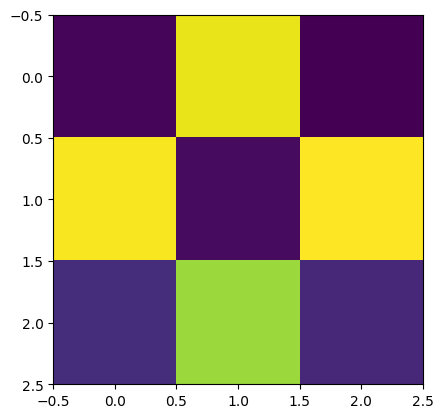

In [47]:
plt.imshow(results[N_STEPS][BOARD_NAME][SEED]['model'].weights[0][:, :, 0, 0])

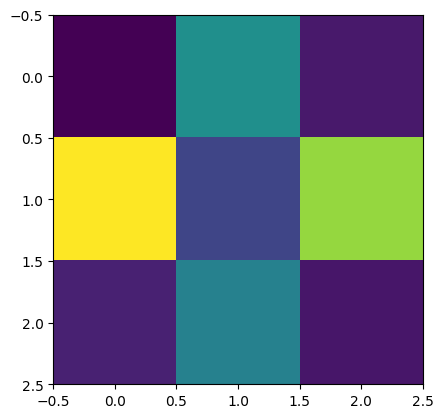

In [48]:
plt.imshow(results[N_STEPS][BOARD_NAME][SEED]['model'].weights[0][:, :, 0, 1])

# #